# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: 540666979, SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
import seaborn as sns

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [193]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

(50000, 32, 32, 3)

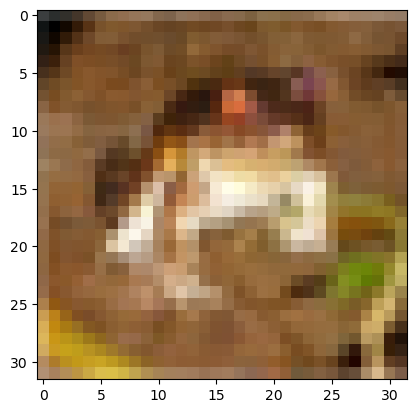

In [194]:
plt.imshow(X_train[0].astype('uint8'))
num_classes = len(np.unique(y_train))
X_train.shape

In [195]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#force the pixel values to have values in the normalized range of [0,1] ensuring that all
#pixels contribute equally to the model
X_train /= 255
X_test /= 255

#standardize the pixel values for each RGB color channels for model optimization
#helping the gradient to converge faster
#implying removing the effect of RGB values from the value of each color and
#forcing each channel to have a near zero mean and unit variance 
mean = X_train.mean(axis=(0,1,2))
std = X_train.std(axis=(0,1,2))

for i in range(3): 
    X_train[..., i] = (X_train[..., i] - mean[i]) / std[i] 
    X_test[..., i] = (X_test[..., i] - mean[i]) / std[i]

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

### Fully connected neural network

In [196]:
def mlp_architecture():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(k_99,)),
        keras.layers.Dense(512),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(10, activation='softmax')
    ])

    learning_rate_decay = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.003,
        decay_steps=5000,
        decay_rate=0.9,
        staircase=True
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate_decay),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [197]:
model = mlp_architecture()
history = model.fit(
    X_train_pca, y_train,
    epochs = 50, 
    validation_split=0.2,
    batch_size=128
)

C:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.2357 - loss: 2.1438 - val_accuracy: 0.4089 - val_loss: 1.6548
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4541 - loss: 1.5246 - val_accuracy: 0.4474 - val_loss: 1.5424
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5308 - loss: 1.3287 - val_accuracy: 0.4688 - val_loss: 1.5022
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5887 - loss: 1.1518 - val_accuracy: 0.4805 - val_loss: 1.4656
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6481 - loss: 0.9953 - val_accuracy: 0.4842 - val_loss: 1.5009
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6887 - loss: 0.8800 - val_accuracy: 0.4928 - val_loss: 1.5177
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7397 - loss: 0.7466 - val_accuracy: 0.4930 - val_loss: 1.5648
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7666 - loss: 0.6657 - val_accuracy: 

In [198]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 658)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         337,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,515,935 (5.78 MB)

 Trainable params: 504,714 (1.93 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 1,009,429 (3.85 MB)

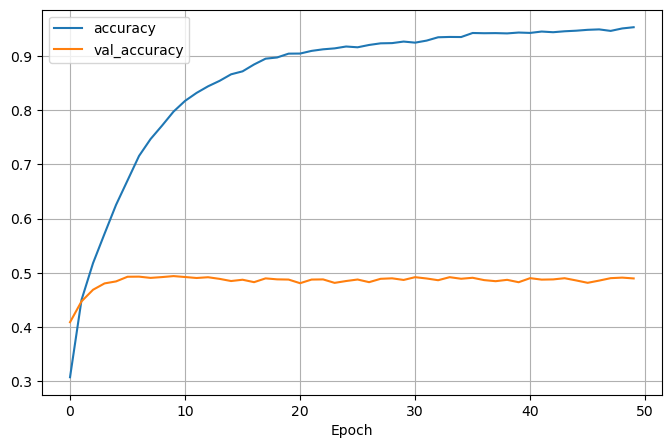

In [199]:
import pandas as pd

# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.xlabel('Epoch')
plt.show()

### Convolutional neural network

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

### Fully connected neural network

In [200]:
def mlp_classifier(hp):
    model = keras.Sequential()
    try:
        model.add(keras.layers.Flatten(input_shape=(32,32,3)))
    
        layer_cnt = hp.Choice('layer_cnt', values=[2,3,4,5])
        for i in range(layer_cnt):
            uts=hp.Choice(f'node_{i}', values=[1024, 512, 256, 128])
            activation = hp.Choice(f'activation_{i}', values=['relu', 'elu', 'tanh', 'sigmoid'])
            model.add(keras.layers.Dense(units=uts))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(activation))            
            model.add(
                keras.layers.Dropout(hp.Choice(f'dropout_{i}', values=[0.1, 0.2, 0.3, 0.4]))
            )
                      
        model.add(keras.layers.Dense(10, activation='softmax'))
        ilr = hp.Choice('initial_learning_rate', values=[1e-2, 1e-3, 1e-4])
    
        use_decay = hp.Boolean('learning_decay')
        if use_decay:
            learning_sched = keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate = ilr,
                decay_steps=int(hp.Int('decay_steps', 1000, 10000, step=1000)),
                decay_rate=float(hp.Float('decay_rate', 0.8, 0.99))
            )
        else:
            learning_sched = ilr
            
        optimizer_name = hp.Choice('optimizer_type', values=['Adam', 'SGD', 'AdamW'])
        mt = hp.Choice('momentum', values=[0.5, 0.6])
        wd = hp.Float('weight_decay', 1e-5, 1e-3, sampling='log')
        
        if optimizer_name == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=learning_sched)
        elif optimizer_name == 'SGD':
            opt = keras.optimizers.SGD(
                learning_rate=learning_sched
            )
        elif optimizer_name == 'AdamW':
            opt = keras.optimizers.AdamW(
                learning_rate=learning_sched,
                weight_decay= wd
            )
            
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
                     )
    except Exception as e:
        print(e)
    return model

#### Code for finding tuning parameter

In [201]:
tuner = BayesianOptimization(
    hypermodel=mlp_classifier,
    objective="val_accuracy",
    max_trials=10,
    max_retries_per_trial=2,
    overwrite=True
)

C:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [202]:
tuner.search(
    X_train, 
    y_train, 
    batch_size=256,
    epochs=50, 
    validation_split=0.2,
    verbose=1
)

Trial 10 Complete [00h 01m 19s]
val_accuracy: 0.5297999978065491

Best val_accuracy So Far: 0.5688999891281128
Total elapsed time: 00h 33m 32s


In [205]:
import pandas as pd

all_trials = tuner.oracle.get_best_trials(num_trials=10)

records = []

metrics = ['loss', 'accuracy', 'val_loss', 'val_accuracy']

for trial in all_trials:
    # Extract hyperparameters as a dict
    hparams = trial.hyperparameters.values.copy()
    
    metrics = {metric: trial.metrics.get_last_value(metric) for metric in metrics}
    record = {**hparams, **metrics}
    records.append(record)

df = pd.DataFrame(records)
df

,layer_cnt,node_0,activation_0,dropout_0,node_1,activation_1,dropout_1,initial_learning_rate,learning_decay,optimizer_type,...,dropout_3,decay_steps,decay_rate,loss,accuracy,val_loss,val_accuracy,node_4,activation_4,dropout_4
0,3,512,relu,0.4,512,elu,0.3,0.0001,False,AdamW,...,0.2,3000,0.833555,0.983053,0.648425,1.271782,0.5689,NaN,NaN,NaN
1,2,1024,tanh,0.3,128,relu,0.2,0.0100,True,AdamW,...,0.2,7000,0.943545,0.713628,0.738725,1.440243,0.5489,512.0,sigmoid,0.4
2,2,1024,elu,0.2,512,relu,0.2,0.0100,True,SGD,...,0.4,8000,0.927890,1.065678,0.632650,1.304409,0.5485,1024.0,tanh,0.1
3,4,128,relu,0.2,1024,relu,0.4,0.0001,False,AdamW,...,0.4,10000,0.863701,1.118108,0.604050,1.329127,0.5451,256.0,tanh,0.3
4,4,1024,sigmoid,0.3,128,sigmoid,0.4,0.0010,False,AdamW,...,0.3,6000,0.970952,1.083271,0.616400,1.338465,0.5410,NaN,NaN,NaN
5,3,128,relu,0.1,1024,sigmoid,0.2,0.0001,False,AdamW,...,0.2,3000,0.859897,0.978621,0.654650,1.398064,0.5363,128.0,sigmoid,0.3
6,3,128,tanh,0.1,512,tanh,0.2,0.0001,True,Adam,...,0.4,5000,0.924067,1.051435,0.629125,1.380622,0.5319,128.0,tanh,0.1
7,2,128,sigmoid,0.2,128,sigmoid,0.2,0.0010,False,Adam,...,0.2,10000,0.820476,1.113860,0.603300,1.363269,0.5298,1024.0,sigmoid,0.4
8,5,128,sigmoid,0.2,256,tanh,0.3,0.0010,False,Adam,...,0.2,1000,0.800621,1.260080,0.550125,1.377697,0.5145,1024.0,relu,0.1
9,4,1024,elu,0.2,1024,elu,0.3,0.0010,True,SGD,...,0.1,1000,0.800000,1.671709,0.408500,1.638088,0.4261,NaN,NaN,NaN


In [206]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp = best_hp.values
best_hp

{'layer_cnt': 3,
 'node_0': 512,
 'activation_0': 'relu',
 'dropout_0': 0.4,
 'node_1': 512,
 'activation_1': 'elu',
 'dropout_1': 0.3,
 'initial_learning_rate': 0.0001,
 'learning_decay': False,
 'optimizer_type': 'AdamW',
 'momentum': 0.5,
 'weight_decay': 2.910229188609541e-05,
 'node_2': 1024,
 'activation_2': 'elu',
 'dropout_2': 0.1,
 'node_3': 1024,
 'activation_3': 'relu',
 'dropout_3': 0.2,
 'decay_steps': 3000,
 'decay_rate': 0.8335545579523798}

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

In [207]:
from kerastuner import HyperParameters

best_hp = {
    'layer_cnt': 4,
     'node_0': 1024,
     'activation_0': 'tanh',
     'dropout_0': 0.4,
     'node_1': 128,
     'activation_1': 'tanh',
     'dropout_1': 0.2,
     'initial_learning_rate': 0.01,
     'learning_decay': False,
     'optimizer_type': 'Adam',
     'momentum': 0.6,
     'weight_decay': 6.673277125154032e-05,
     'node_2': 256,
     'activation_2': 'elu',
     'dropout_2': 0.2,
     'node_3': 1024,
     'activation_3': 'elu',
     'dropout_3': 0.2,
     'decay_steps': 7000,
     'decay_rate': 0.8015248428236272,
     'node_4': 128,
     'activation_4': 'relu',
     'dropout_4': 0.4
}

tuner_hyperparameter = HyperParameters()
for key, value in best_hp.items():
    tuner_hyperparameter.values[key] = value
tuner_hyperparameter.values

{'layer_cnt': 4,
 'node_0': 1024,
 'activation_0': 'tanh',
 'dropout_0': 0.4,
 'node_1': 128,
 'activation_1': 'tanh',
 'dropout_1': 0.2,
 'initial_learning_rate': 0.01,
 'learning_decay': False,
 'optimizer_type': 'Adam',
 'momentum': 0.6,
 'weight_decay': 6.673277125154032e-05,
 'node_2': 256,
 'activation_2': 'elu',
 'dropout_2': 0.2,
 'node_3': 1024,
 'activation_3': 'elu',
 'dropout_3': 0.2,
 'decay_steps': 7000,
 'decay_rate': 0.8015248428236272,
 'node_4': 128,
 'activation_4': 'relu',
 'dropout_4': 0.4}

In [208]:
model = mlp_classifier(tuner_hyperparameter)
history = model.fit(
    X_train, y_train, 
    epochs=50,
    batch_size=256,
    validation_split=0.2
)

C:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.2074 - loss: 2.9060 - val_accuracy: 0.3044 - val_loss: 2.0677
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3155 - loss: 1.9296 - val_accuracy: 0.3462 - val_loss: 1.8062
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.3681 - loss: 1.7802 - val_accuracy: 0.3626 - val_loss: 1.7930
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.3946 - loss: 1.6893 - val_accuracy: 0.4205 - val_loss: 1.6271
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4181 - loss: 1.6256 - val_accuracy: 0.4542 - val_loss: 1.5417
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4483 - loss: 1.5436 - val_accuracy: 0.4464 - val_loss: 1.5517
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4633 - loss: 1.4994 - val_accuracy: 0.4486 - val_loss: 1.5519
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4738 - loss: 1.4663 - val_acc

In [209]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,772,640 (41.09 MB)

 Trainable params: 3,589,258 (13.69 MB)

 Non-trainable params: 4,864 (19.00 KB)

 Optimizer params: 7,178,518 (27.38 MB)

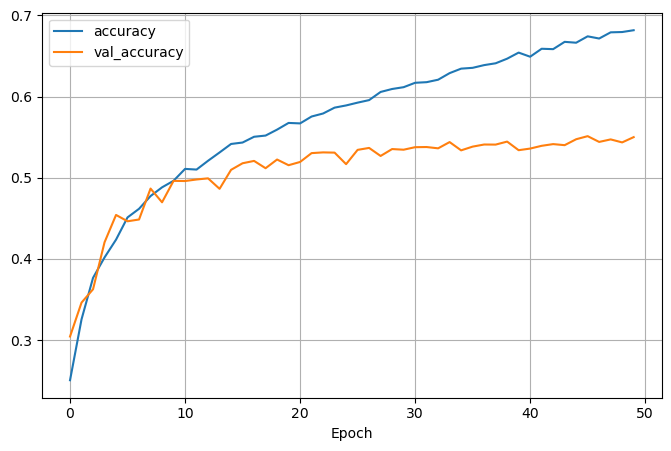

In [210]:
import pandas as pd

accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.xlabel('Epoch')
plt.show()

In [211]:
y_prob = model.predict(X_test, batch_size=512)
y_pred = np.argmax(y_prob, axis=1)
f1_macro  = f1_score(y_test, y_pred, average='macro')
print("Macro f1 score of the model with best hyperparameters", f1_macro)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Macro f1 score of the model with best hyperparameters 0.5486191515904665


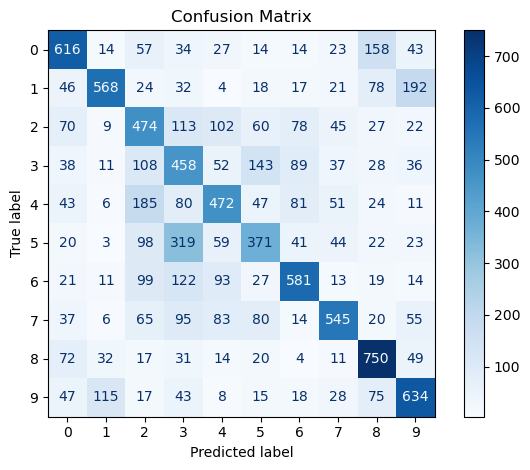

In [212]:
cm = confusion_matrix(y_test, y_pred)
conf_mat = ConfusionMatrixDisplay(confusion_matrix=cm)
conf_mat.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

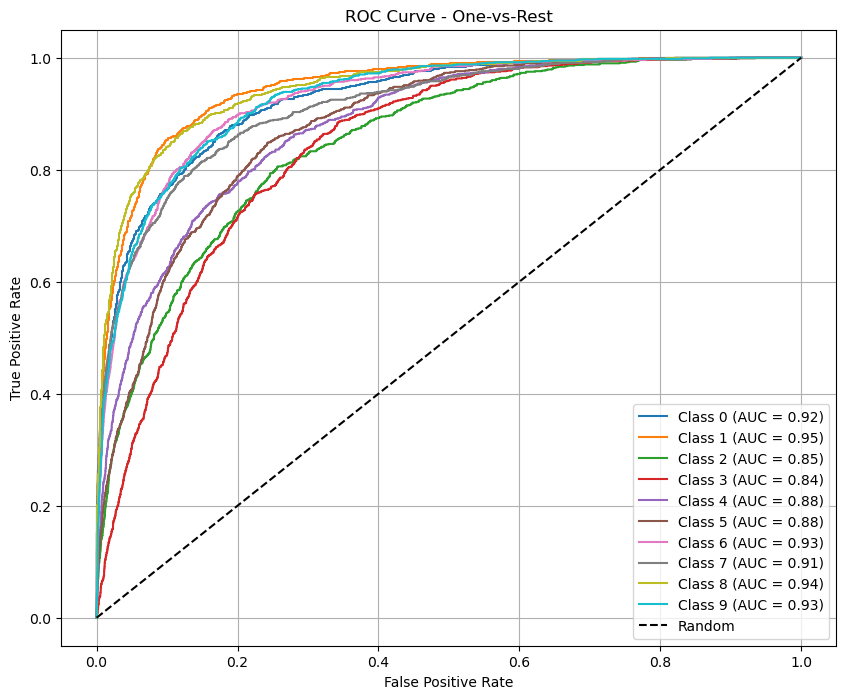

In [213]:
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=len(list(np.unique(y_test))))

plt.figure(figsize=(10,8))
for i in range(len(list(np.unique(y_test)))):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend()
plt.grid(True)
plt.show()

### Convolutional neural network